In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

from rna_motif_library.plotting import (
    publication_style_ax,
    calculate_subplot_coordinates,
    merge_sequential_coords,
    load_and_fit_image_to_subplot,
    draw_box_around_figure,
)

In [2]:
df_hbonds = pd.read_csv("../../data/summaries/hbonds/non_redundant_hbonds.csv")

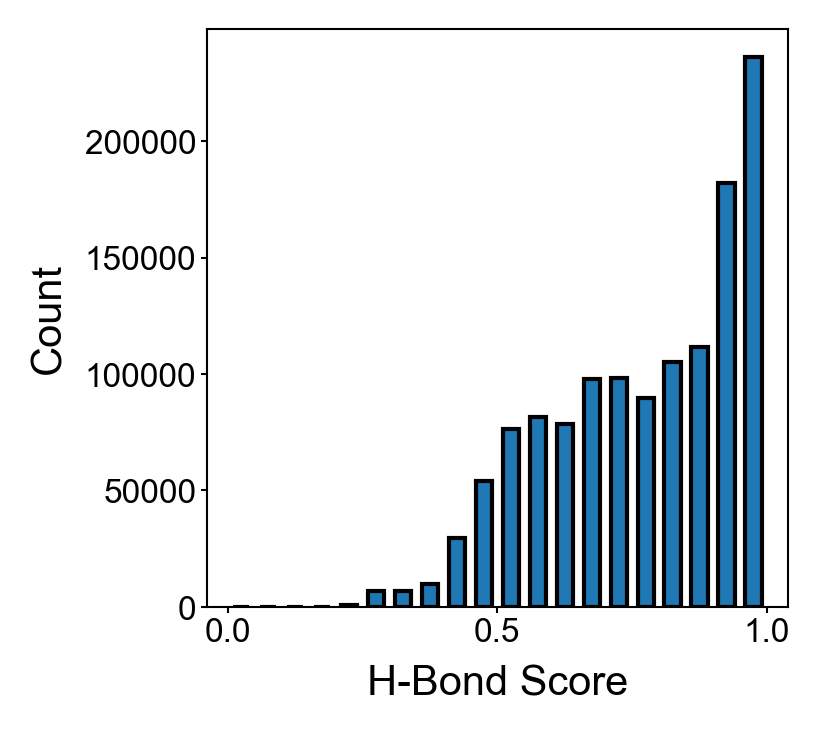

In [3]:
scores = df_hbonds["hbond_score"].dropna()
bin_edges = np.arange(0, 1.05, 0.05)

fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

plt.hist(scores, bins=bin_edges, rwidth=0.6, edgecolor="black")
plt.xlabel("H-Bond Score")
plt.ylabel("Count")
publication_style_ax(ax)

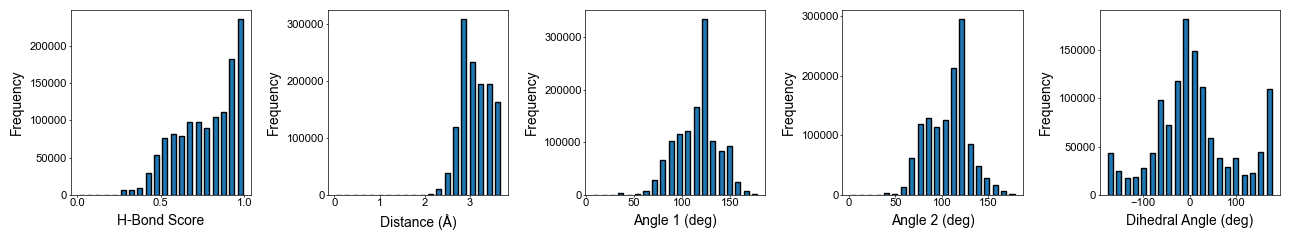

In [4]:
columns = [
    ("hbond_score", "H-Bond Score", np.arange(0, 1.05, 0.05)),
    ("distance", "Distance (Å)", 20),
    ("angle_1", "Angle 1 (deg)", 20),
    ("angle_2", "Angle 2 (deg)", 20),
    ("dihedral_angle", "Dihedral Angle (deg)", 20),
]

fig, axes = plt.subplots(1, 5, figsize=(13, 2.5), sharex=False)

for ax, (col, xlabel, bins) in zip(axes, columns):
    data = df_hbonds[col].dropna()
    ax.hist(data, bins=bins, rwidth=0.6, edgecolor="black")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")
    # ax.set_title(f'Histogram of {xlabel}')
    publication_style_ax(ax)
plt.tight_layout()
plt.show()

I think it would be interesting to see if there is a correlation between the type of h-bond (base pairing, sugar hydrogen bond, phosphate, etc) and the score
4/5 of the 0.9 were base pairs.

In [5]:
sampled = df_hbonds[df_hbonds["hbond_score"] > 0.9].sample(5, random_state=42)

In [6]:
sampled.head()

,res_id_1,res_id_2,atom_name_1,atom_name_2,res_type_1,res_type_2,distance,angle_1,angle_2,dihedral_angle,hbond_score,pdb_id
791839,A-G-7-,B-C-66-,O6,N4,RNA,RNA,2.96,117.0,119.2,-23.1,0.954,3GVN
266544,1a-A-1447-,1a-C-1452-,O2P,N4,RNA,RNA,2.99,166.2,101.7,28.8,0.903,9D0J
797601,BA-C-2148-,BA-G-2139-,N3,N1,RNA,RNA,2.92,121.6,118.9,164.5,0.972,6SKG
992165,A-U-172-,A-G-165-,O2,N1,RNA,RNA,2.84,85.4,82.9,171.9,0.940,8TJV
556470,AR-A-1654-,AR-U-1801-,N1,N3,RNA,RNA,2.80,116.3,114.7,3.8,0.973,8P9A


sampled      >0.9,
sampled_2    0.80-0.70,
sampled_3    0.55-0.45, 
sampled_4    0.20-0.30, 
sampled_5    <0.1

In [11]:
def load_and_fit_image_to_subplot(image_path, subplot_coords, fig, ax):
    """
    Load an image from file and stretch it to fit in a subplot.

    Parameters:
    -----------
    image_path : str
        Path to the image file
    subplot_coords : tuple
        Subplot coordinates as (left, bottom, width, height) in figure-relative units
    fig : matplotlib.figure.Figure
        The figure object
    ax : matplotlib.axes.Axes
        The axes object where the image will be placed

    Returns:
    --------
    matplotlib.image.AxesImage
        The image object that was added to the subplot
    """

    # Load the image
    try:
        img = mpimg.imread(image_path)
    except Exception as e:
        raise ValueError(f"Could not load image from {image_path}: {e}")

    # Clear the axes
    ax.clear()

    # Display the image stretched to fit the subplot
    img_plot = ax.imshow(img)

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    return img_plot

In [ ]:
# Yes, there are several ways to trim/crop an image when loading with mpimg.imread():


# Method 1: Using array slicing after loading
def load_and_fit_image_to_subplot_trimmed(
    image_path, subplot_coords, fig, ax, crop_box=None
):
    """
    Load an image from file, optionally crop it, and stretch it to fit in a subplot.

    Parameters:
    -----------
    image_path : str
        Path to the image file
    subplot_coords : tuple
        Subplot coordinates as (left, bottom, width, height) in figure-relative units
    fig : matplotlib.figure.Figure
        The figure object
    ax : matplotlib.axes.Axes
        The axes object where the image will be placed
    crop_box : tuple, optional
        Crop box as (left, top, right, bottom) in pixels. If None, no cropping is done.

    Returns:
    --------
    matplotlib.image.AxesImage
        The image object that was added to the subplot
    """

    # Load the image
    try:
        img = mpimg.imread(image_path)
    except Exception as e:
        raise ValueError(f"Could not load image from {image_path}: {e}")

    # Crop the image if crop_box is provided
    if crop_box is not None:
        left, top, right, bottom = crop_box
        img = img[top:bottom, left:right]

    # Clear the axes
    ax.clear()

    # Display the image stretched to fit the subplot
    img_plot = ax.imshow(img, extent=[0, 1, 0, 1], aspect="auto")

    # Set the subplot position
    ax.set_position(subplot_coords)

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    return img_plot


# Method 2: Using PIL for more advanced cropping
from PIL import Image
import numpy as np


def load_and_fit_image_to_subplot_pil(
    image_path, subplot_coords, fig, ax, crop_box=None
):
    """
    Load an image using PIL, optionally crop it, and stretch it to fit in a subplot.

    Parameters:
    -----------
    image_path : str
        Path to the image file
    subplot_coords : tuple
        Subplot coordinates as (left, bottom, width, height) in figure-relative units
    fig : matplotlib.figure.Figure
        The figure object
    ax : matplotlib.axes.Axes
        The axes object where the image will be placed
    crop_box : tuple, optional
        Crop box as (left, top, right, bottom) in pixels. If None, no cropping is done.

    Returns:
    --------
    matplotlib.image.AxesImage
        The image object that was added to the subplot
    """

    # Load the image with PIL
    try:
        pil_img = Image.open(image_path)
    except Exception as e:
        raise ValueError(f"Could not load image from {image_path}: {e}")

    # Crop the image if crop_box is provided
    if crop_box is not None:
        pil_img = pil_img.crop(crop_box)

    # Convert PIL image to numpy array
    img = np.array(pil_img)

    # Clear the axes
    ax.clear()

    # Display the image stretched to fit the subplot
    img_plot = ax.imshow(img, extent=[0, 1, 0, 1], aspect="auto")

    # Set the subplot position
    ax.set_position(subplot_coords)

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    return img_plot


# Example usage:
# crop_box = (100, 50, 400, 300)  # (left, top, right, bottom) in pixels
# load_and_fit_image_to_subplot_trimmed(path, coords_list[0], fig, ax1, crop_box=crop_box)

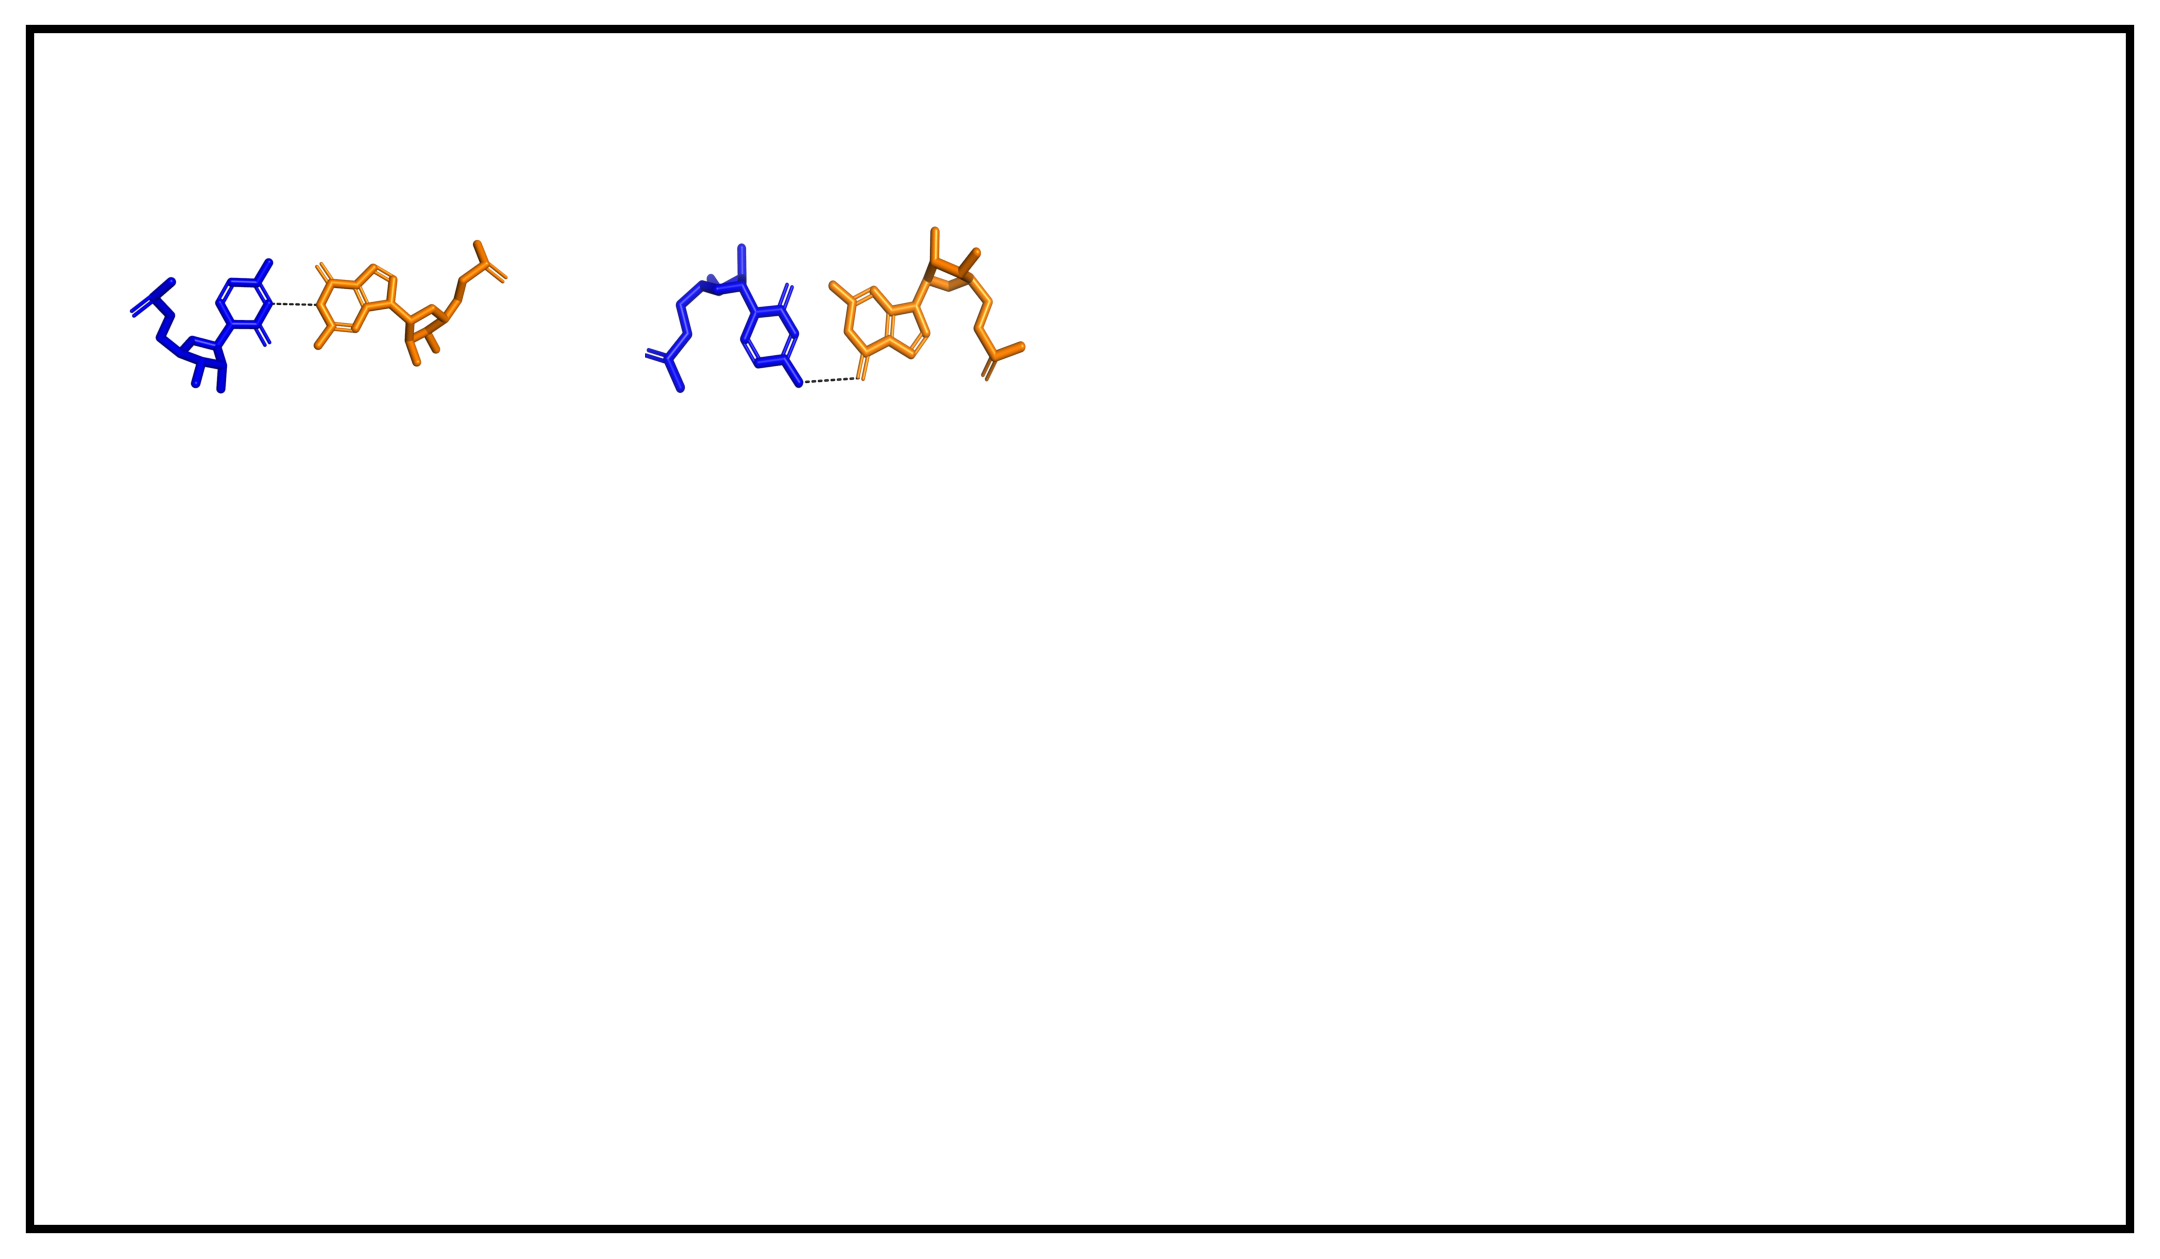

In [16]:
fig_size = (7, 4)
layout = (2, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.40,  # vertical spacing in inches
    "margins": {"left": 0.30, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=(7, 4), dpi=300)

path = "../../figures/images/hbond_example_1.png"
ax1 = fig.add_axes(coords_list[0])
load_and_fit_image_to_subplot(path, coords_list[0], fig, ax1)

path = "../../figures/images/hbond_score_2.png"
ax2 = fig.add_axes(coords_list[1])
load_and_fit_image_to_subplot(path, coords_list[1], fig, ax2)


draw_box_around_figure(fig, linewidth=2, edgecolor="black")